In [495]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [496]:
class Range:
    def __init__(self, min: float, max: float) -> None:
        """
        Rozsah hodnot

        Parametry:
            min - minimalni hodnota rozsahu
            max - maximalni hodnota rozsahu
        """
        self.min = min
        self.max = max

    def size(self):
        """
        Vypocita velikost rozsahu
        """
        return self.max - self.min

# Trida pro Particle

In [497]:
class Particle:
    def __init__(self, dim: int, vmax: float, range: Range):
        """
        Trida pro particle

        Parametry:
            dim - dimenze castice
            vmax - maximalni rychlost pohybu castice
            range - rozsah hodnot reseni
        """
        self.position = np.random.uniform(range.min, range.max, size=dim)
        self.velocity = np.random.uniform(-vmax, vmax, size=dim)
        self.personal_best_pos = self.position.copy()
        self.personal_best_val = float('inf')

    def get_position(self):
        """
        Navrati aktualni pozici castice
        """
        return self.position

    def get_velocity(self):
        """
        Navrati aktualni rychlost castice
        """
        return self.velocity

    def get_personal_best_position(self):
        """
        Navrati pozici nejlepsi nalazenou hodnotu castice
        """
        return self.personal_best_pos

    def get_personal_best_value(self):
        """
        Navrati nejlepsi nalazenou hodnotu castice
        """
        return self.personal_best_val

    def set_position(self, position):
        """
        Nastavi castici novou pozici

        Parametry:
            position - nova pozice castice     
        """
        self.position = position

    def update_personal_best(self, obj_func):
        """
        Aktualizuje nejlepsi pozicizi castice. Pokud je aktualni pozice lepe ohodnoceny nez drive personalne nejlepe ohodnocena pozice tak je prepsana

        Parametry:
            obj_func - funkce optimalizovaneho problemu (urcuje kvalitu aktualni pozice)
        """
        new_value = obj_func(self.position)
        if new_value < self.personal_best_val:
            self.personal_best_val = new_value
            self.personal_best_pos = self.position.copy()

# Trida pro Particle swarm

In [498]:
PS_TOPOLOGY_GLOBAL = 'global'
PS_TOPOLOGY_RING = 'ring'


class ParticleSwarm:
    def __init__(self, dim: int, nparticles: int, vmax: float, range: Range, topology=PS_TOPOLOGY_GLOBAL) -> None:
        """
        Trida pro Particle swarm

        Parametry:
            dim - dimenze castic
            nparticles - pocet castic v roji
            vmax - maximalni rychlost pohybu castic
            range - rozsah hodnot reseni
            topology - topologie 
        """
        self.dim = dim
        self.nparticles = nparticles
        self.vmax = vmax
        self.topology = topology
        self.range = range
        self.propts = {}
        self.random_init(None)

    def setProperty(self, name: str, value):
        """
        Nastavi libovolnou konfigurace pro roj castic
        """
        self.propts[name] = value

    def random_init(self, obj_func):
        """
        Nahodna inicializace/reinicializace roje castic

        Parametry:
            obj_func - funkce optimalizovaneho problemu (urcuje kvalitu aktualni pozice)
        """
        self.global_best_pos = None
        self.global_best_val = float('inf')
        self.particles = [Particle(self.dim, self.vmax, self.range)
                          for _ in range(self.nparticles)]
        if obj_func is not None:
            for p in self.particles:
                p.update_personal_best(obj_func)
                self.update_global_best_with_one_particle(p)

    def get_particles(self):
        """
        Navrati vsechny castice
        """
        return self.particles

    def get_range(self):
        """
        Navrati rozsaho hodnot reseni
        """
        return self.range

    def get_dim(self):
        """
        Navrati dimenzi castic
        """
        return self.dim

    def get_vmax(self):
        """
        Navrati maximalni rychlost pohybu castic
        """
        return self.vmax

    def get_global_best(self):
        """
        Navrati nejlepsi nalezenou hodnotu

        Return:
            pozice nejlepsiho reseni, hodnota nejelepsiho reseni      
        """
        return self.global_best_pos, self.global_best_val

    def update_global_best_with_one_particle(self, particle: Particle):
        """
        Update novou globalne nejlepsi hodnotu.

        Parametry:
            particle - castice jejiz personalni nejlepsi hodnota muze byt nastavena jako globalne nejlepsi   
        """
        if particle.get_personal_best_value() < self.global_best_val:
            self.global_best_val = particle.get_personal_best_value()
            self.global_best_pos = particle.get_personal_best_position().copy()

    def get_neighbors_best(self, particle_index: int):
        """
        Navrati nejlepsi nalezenou hodnotu v sousedstvi v zavyslosti na zvolene topologii roje castic

        Parametry:
            particle_index - index vybrana castice

        Return:
             pozice nejlepsiho reseni, hodnota nejelepsiho reseni    
        """
        n_best_pos = None
        n_best_value = float('inf')

        if self.topology == PS_TOPOLOGY_GLOBAL:
            n_best_pos = self.global_best_pos
            n_best_value = self.global_best_val
        elif self.topology == PS_TOPOLOGY_RING:
            n_best_pos, n_best_value = self.get_ring_neighbors_best(
                particle_index, int(self.propts["RING_SIZE"]))
        else:
            raise ValueError("Unsupported topology!!")

        return n_best_pos, n_best_value

    def get_ring_neighbors_best(self, particle_index, size: int):
        """
        Z kruhoveho sousedstvi navrati nejlepsi nelazenou hodnotu

        Parametry:
            particle_index - index castice ktera je stredem sousedstvi
            size - velikost sousedstvi

        Return:
            pozice nejlepsiho reseni, hodnota nejelepsiho reseni   
        """
        neighbor_best_pos = None
        neighbor_best_value = float('inf')
        for i in range(particle_index - size, particle_index + size + 1):
            neighbor_index = i % self.nparticles
            if self.particles[neighbor_index].get_personal_best_value() < neighbor_best_value:
                neighbor_best_value = self.particles[neighbor_index].get_personal_best_value(
                )
                neighbor_best_pos = self.particles[neighbor_index].get_personal_best_position(
                )

        return neighbor_best_pos, neighbor_best_value

# Trida implementujici optimalizacni algoritmus PSO

In [499]:
PSO_TOPOLOGY_GLOBAL = 'global'
PSO_TOPOLOGY_RING = 'ring'


class PSO:
    def __init__(self, p_swarm: ParticleSwarm, obj_func, max_iter: int, w_func: float, c1: float, c2: float):
        """
        Trida implementujici PSO optimalizacni algoritmus

        Parametry:
            p_swarm - Reference na roj castic
            obj_func - funkce optimalizovaneho problemu   
            max_iter - maximalni pocet iteraci
            w - funkce vypoctu setrvacnosti. Predpist w_func(iterace, pocet iteraci)
            c1 - ucici faktor 1
            c2 - ucici faktor 2
        """
        self.p_swarm = p_swarm
        self.obj_func = obj_func
        self.max_iter = max_iter
        self.w_func = w_func
        self.c1 = c1
        self.c2 = c2

        # callback pro reset (reference_pso)
        self.reset_callback = []
        # callback pro iteraci (reference_pso, particles, gbest_pos, gbest_value)
        self.iteration_callback = []

    def optimize(self):
        # zavola callback pro reset
        self.__invokeResetCallback()

        # nahodna inicializace
        self.p_swarm.random_init(self.obj_func)

    
        for iteration in range(self.max_iter):
            # zavola callback pro odeslani aktualniho stavu
            self.__invokeIterationCallback()

            for i, particle in enumerate(self.p_swarm.get_particles()):
                # nahodna generovani cisel pro vypocet rychlosti
                r1, r2 = np.random.rand(self.p_swarm.get_dim()), np.random.rand(
                    self.p_swarm.get_dim())

                # nalezeni nejlepsi pozice ze sousedstvi (hodnota je zavysla na typu topologie ve p_swam objektu)
                neighbors_best_position, _ = self.p_swarm.get_neighbors_best(
                    i)
                if neighbors_best_position is None:
                    raise ValueError("Failed to get neighbors best!")

                # vypocet nove pozice aktualne zpracovavane castice
                particle_velocity = (
                    self.w_func(i, self.max_iter) * particle.get_velocity() +
                    self.c1 * r1 * (particle.get_personal_best_position() - particle.get_position()) +
                    self.c2 * r2 * (neighbors_best_position -
                                    particle.get_position())
                )
                particle_position = particle.get_position() + particle_velocity
                particle_position = np.clip(
                    particle_position, self.p_swarm.get_range().min, self.p_swarm.get_range().max)

                # nastaveni nove vypoctene pozice
                particle.set_position(particle_position)

                # update personalni nejlepsi pozice castice
                particle.update_personal_best(self.obj_func)

                # update globalni nejlepsi pozice
                self.p_swarm.update_global_best_with_one_particle(particle)

        return self.p_swarm.get_global_best()
    
    def __invokeResetCallback(self):
        for callback in self.reset_callback:
            callback(self)


    def __invokeIterationCallback(self):
        for callback in self.iteration_callback:
            p, v = self.p_swarm.get_global_best()
            callback(self, self.p_swarm.particles, p.copy(), v)

# PSO Vizualize pro vyzualizaci Particle Swarm

In [500]:
class PSState:
    def __init__(self, particles, gbest_pos, gbest_value):
        self.particles = []
        for p in particles:
            self.particles.append(p.get_position().copy())
        self.gbest_pos = gbest_pos
        self.gbest_value = gbest_value

class PSOVisualizer:
    def __init__(self):
        self.particle_states = {}

    def bind(self, pso: PSO):
        pso.reset_callback.append(self.__reset_callback)
        pso.iteration_callback.append(self.__iteration_callback)

    def __reset_callback(self, pso_ref):
        self.particle_states[pso_ref] = None

    def __iteration_callback(self, pso_ref, particles, gbest_pos, gbest_value):
        if self.particle_states[pso_ref] is None:
            self.particle_states[pso_ref] = []
        self.particle_states[pso_ref].append(PSState(particles, gbest_pos, gbest_value))

    def __split_iter_range(self, end, count):
        iters = []
        krok = (end - 0) / (count - 1)
        for i in range(count - 1):
            hodnota = round(i * krok)
            iters.append(hodnota)
        iters.append(end)
        return iters

    def plot_ps_states(self, pso_ref, count):
        row_count = math.ceil(count / 4)
        iters = self.__split_iter_range(end=len(self.particle_states[pso_ref])-1, count=count)
        fig, axes = plt.subplots(row_count, min(count, 4), figsize=(19, (18/4)*row_count))
        for i in range(count):
            current_row = int(i/4)
            if row_count > 1:
                self.plot_ps_state(axes[current_row, i % 4], pso_ref, iters[i])
            else:
                self.plot_ps_state(axes[i % 4], pso_ref, iters[i])
        plt.show()

    def plot_ps_state(self, axes, pso_ref, iteration):
        state = self.particle_states[pso_ref][iteration]
        positions = np.array([pos for pos in state.particles])
        axes.scatter(positions[:, 0], positions[:, 1], color='r', marker='o', label='Particles')
        axes.scatter(state.gbest_pos[0], state.gbest_pos[1], color='g', marker='*', label='gBest')
        axes.set_title(f'Iteraton = {iteration}')
        axes.set_xlabel('X')
        axes.set_ylabel('Y')
        axes.legend()

    def plot_convergence_graph(self, pso_ref):
        plt.figure(figsize=(10, 5))
        states = self.particle_states[pso_ref]
        curve = [s.gbest_value for s in states]
        plt.semilogy(curve)
        plt.xlabel('Iteration')
        plt.ylabel('gBest Value')
        plt.title('Convergence graph')
        plt.show()

# Testovaci funkce

In [501]:
def sphere_function(x):
    return np.sum(x**2)

def rastrigins_function(x):
    return 10 * len(x) + np.sum(x**2 - 10 * np.cos(2 * np.pi * x))

def rosenbrock_function(x):
    return np.sum(100.0 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

# Globalni nastaveni

In [502]:
dim = 2
nparticles = 50
xRange = Range(-20.0, 20.0)
vmax = 0.2 * xRange.size()

# Metody s definici setrvacnosti

In [503]:
def w_func_linear(iteration: int, max_iterations: int):
    return (0.8 - ((0.8 - 0.3) * iteration) / max_iterations)

def w_func_constant_07(iteration: int, max_iterations: int):
    return 0.7

def w_func_constant_06(iteration: int, max_iterations: int):
    return 0.6

# Instance vizualizeru

In [504]:
visualizer = PSOVisualizer()

# Vytvoreni vsechy PS a PSO

In [505]:
# lineární setrvačnost (w = 0.8 -> 0.3), c1 = c2 = 2, globální topologie (hvězda)
ps1 = ParticleSwarm(dim=dim, nparticles=nparticles, vmax=vmax, range=xRange, topology=PS_TOPOLOGY_GLOBAL)
pso1 = PSO(p_swarm=ps1, obj_func=rosenbrock_function, max_iter=200, w_func=w_func_linear, c1=2.0, c2=2.0)
visualizer.bind(pso=pso1)

# konstantní setrvačnost w = 0.7, c1 = c2 = 1.49618, globální topologie (hvězda)
ps2 = ParticleSwarm(dim=dim, nparticles=nparticles, vmax=vmax, range=xRange, topology=PS_TOPOLOGY_GLOBAL)
pso2 = PSO(p_swarm=ps2, obj_func=rosenbrock_function, max_iter=200, w_func=w_func_constant_07, c1=1.49618, c2=1.49618)
visualizer.bind(pso=pso2)

# konstantní setrvačnost w = 0.6, c1 = c2 = 1.49618 kruhová topologie (velikost sousedství 2)
ps3 = ParticleSwarm(dim=dim, nparticles=nparticles, vmax=vmax, range=xRange, topology=PS_TOPOLOGY_RING)
ps3.setProperty("RING_SIZE", 2)
pso3 = PSO(p_swarm=ps3, obj_func=rosenbrock_function, max_iter=200, w_func=w_func_constant_06, c1=1.49618, c2=1.49618)
visualizer.bind(pso=pso3)

# Optimalizace

In [506]:
gbest_pos1, gbest_val1 = pso1.optimize()
gbest_pos2, gbest_val2 = pso2.optimize()
gbest_pos3, gbest_val3 = pso3.optimize()

# Vysledek 1
lineární setrvačnost (w = 0.8 -> 0.3), c1 = c2 = 2, globální topologie (hvězda)

Position of gBest: [0.99892603 1.00572112]
Value of gBest: 0.0061915499442008635


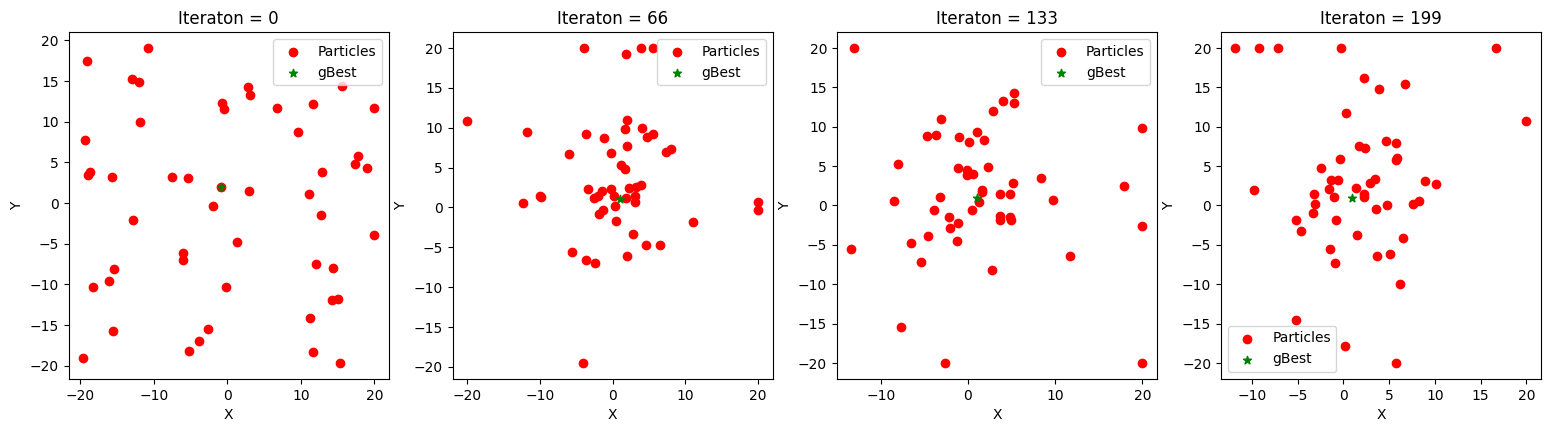

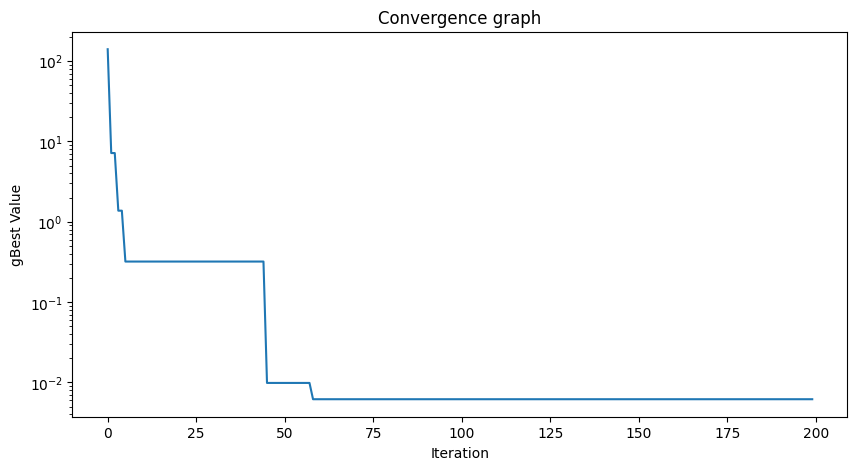

In [507]:
print(f"Position of gBest: {gbest_pos1}")
print(f"Value of gBest: {gbest_val1}")
visualizer.plot_ps_states(pso_ref=pso1, count=4)
visualizer.plot_convergence_graph(pso_ref=pso1)

# Vysledek 2
konstantní setrvačnost w = 0.7, c1 = c2 = 1.49618, globální topologie (hvězda)

Position of gBest: [0.9851406  0.96526052]
Value of gBest: 0.0029681026808433255


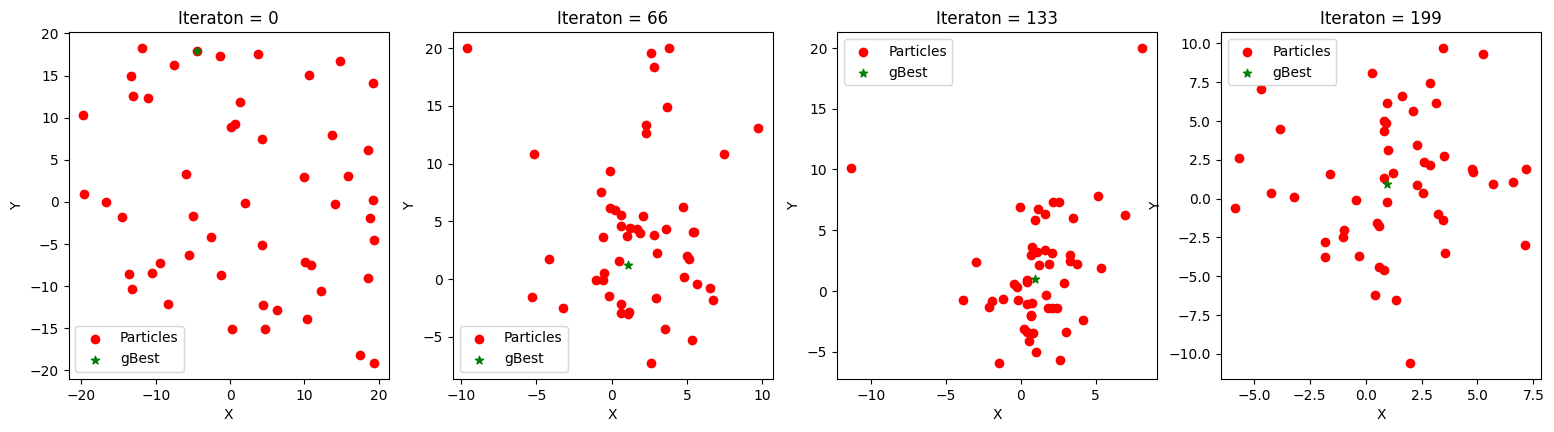

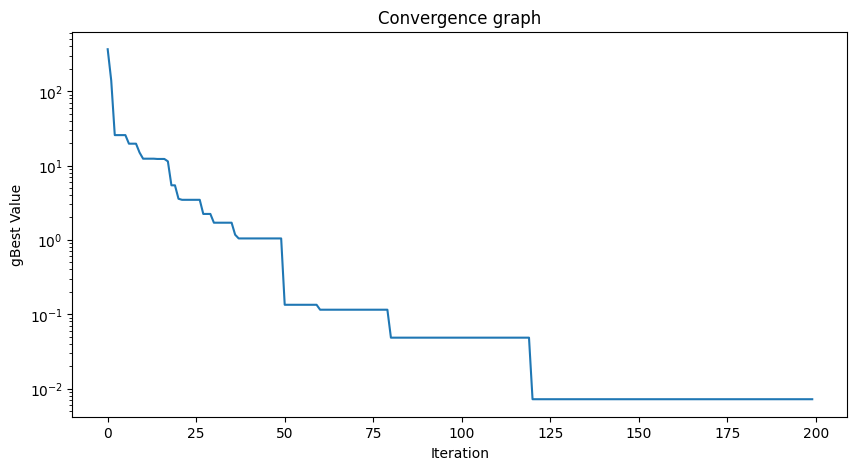

In [508]:
print(f"Position of gBest: {gbest_pos2}")
print(f"Value of gBest: {gbest_val2}")
visualizer.plot_ps_states(pso_ref=pso2, count=4)
visualizer.plot_convergence_graph(pso_ref=pso2)

# Vysledek 3
konstantní setrvačnost w = 0.6, c1 = c2 = 1.49618 kruhová topologie (velikost sousedství 2)

Position of gBest: [1.03901264 1.08406075]
Value of gBest: 0.0035591356750004533


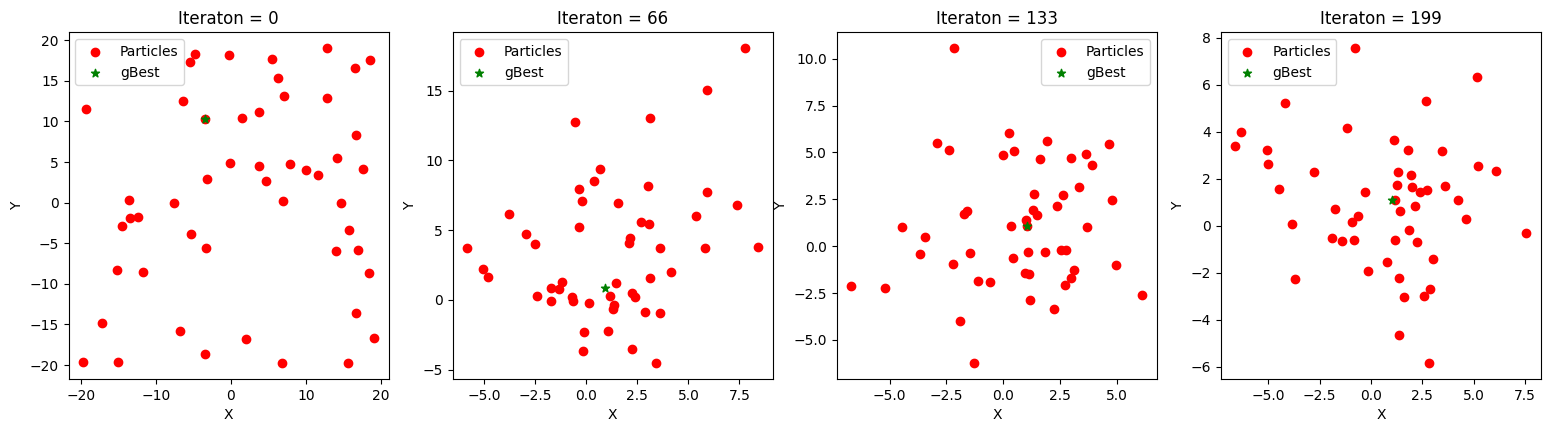

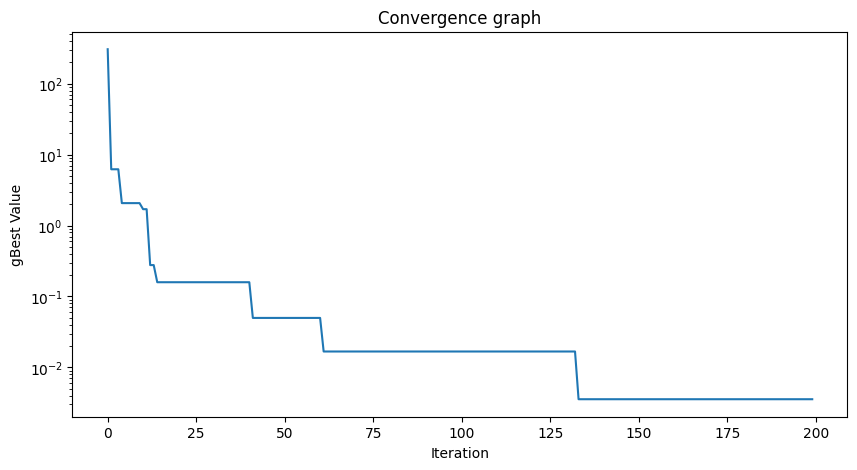

In [509]:
print(f"Position of gBest: {gbest_pos3}")
print(f"Value of gBest: {gbest_val3}")
visualizer.plot_ps_states(pso_ref=pso3, count=4)
visualizer.plot_convergence_graph(pso_ref=pso3)

# Optimalizece pro 6D Rosenbrock

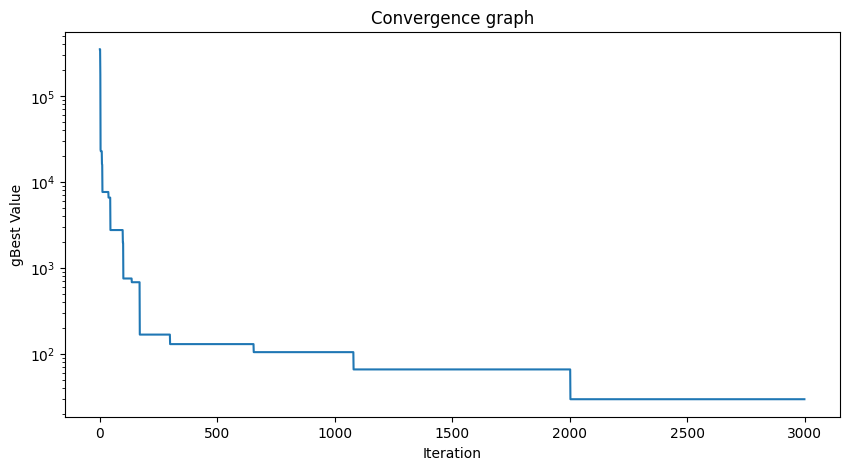

Position of gBest: [ 0.76991629  0.39107162 -0.06434359  0.20916201 -0.05757652 -0.34792633]
Value of gBest: 29.65693671799972


In [536]:
ps4 = ParticleSwarm(dim=6, nparticles=70, vmax=vmax, range=xRange, topology=PS_TOPOLOGY_RING)
ps4.setProperty("RING_SIZE", 2)
pso4 = PSO(p_swarm=ps4, obj_func=rosenbrock_function, max_iter=3000, w_func=w_func_constant_07, c1=2.0, c2=2.0)
visualizer.bind(pso=pso4)
gbest_pos4, gbest_val4 = pso4.optimize()
visualizer.plot_convergence_graph(pso_ref=pso4)
print(f"Position of gBest: {gbest_pos4}")
print(f"Value of gBest: {gbest_val4}")

# Zaver
Po provedení testování algoritmu PSO na testovací funkci Rosenbrock jsme získali následující výsledky.

Varianta 1 s lineární setrvačností (w = 0.8 -> 0.3), c1 = c2 = 2 a globální topologií (hvězda) gBest dosáhla hodnoty přibližne 0.00619 s pozicí [0.99892603, 1.00572112].

Varianta 2 s konstantní setrvačností (w = 0.7), c1 = c2 = 1.49618 a globální topologií (hvězda) gBest dosáhla hodnoty přibližne 0.00297 s pozicí [0.9851406, 0.96526052].

Varianta 3 s konstantní setrvačností (w = 0.6), c1 = c2 = 1.49618 a kruhovou topologií (velikost sousedství 2) gBest dosáhla hodnoty přibližne 0.00355 s pozicí [1.03901264, 1.08406075].

Všechny byli testovaný na stejný počet iteraci a se stejným počtem částic. Celkově lze říct, že všechny tři varianty PSO dosáhly přijatelných výsledků v konvergenci k globálnímu minimu funkce Rosenbrock.